<a href="https://colab.research.google.com/github/seohyun126/Competition/blob/main/Aimers_%EC%A0%84%EC%B2%98%EB%A6%AC_3%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **데이터 불러오기**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
train=pd.read_csv('/content/drive/MyDrive/Aimers_data/train.csv').drop(columns=['ID'])
test=pd.read_csv("/content/drive/MyDrive/Aimers_data/test.csv").drop(columns=['ID'])
submission=pd.read_csv("/content/drive/MyDrive/Aimers_data/sample_submission.csv")

In [ ]:
train2=pd.read_csv('/content/drive/MyDrive/Aimers_data/train.csv').drop(columns=['ID'])
test2=pd.read_csv("/content/drive/MyDrive/Aimers_data/test.csv").drop(columns=['ID'])

### **보정된 나이**

In [ ]:
age_table=pd.concat([train[train['난자 출처']=='본인 제공'].groupby('시술 당시 나이')['임신 성공 여부'].mean(),
            train[train['난자 출처']=='알 수 없음'].groupby('시술 당시 나이')['임신 성공 여부'].mean(),
          ],axis=1)
age_table.columns=['본인 제공','출처 알 수 없음']
train_age4=train[train['난자 출처']=='기증 제공']
age_table2=train_age4.pivot_table(values='임신 성공 여부', index='시술 당시 나이',columns='난자 기증자 나이',aggfunc='mean')
age_result=pd.concat([age_table,age_table2],axis=1)
age_result

,본인 제공,출처 알 수 없음,만20세 이하,만21-25세,만26-30세,만31-35세,알 수 없음
시술 당시 나이,,,,,,,
만18-34세,0.325815,0.194592,0.285714,0.317460,0.344639,0.297089,0.246637
만35-37세,0.280439,0.151034,0.161290,0.350230,0.341651,0.310345,0.288194
만38-39세,0.215694,0.102564,0.187500,0.336449,0.360721,0.328616,0.243697
만40-42세,0.145823,0.069498,0.328358,0.339216,0.353516,0.322751,0.227011
만43-44세,0.064107,0.019093,0.304348,0.362283,0.370198,0.328723,0.236967
만45-50세,0.028216,0.003817,0.244444,0.300741,0.327869,0.268325,0.264925
알 수 없음,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train['보정된 나이']=7.0 # 시술 당시 나이가 알 수 없음 일 경우
train.loc[train['시술 당시 나이']=='만18-34세','보정된 나이']=1.0
train.loc[train['시술 당시 나이']=='만35-37세','보정된 나이']=2.0
train.loc[train['시술 당시 나이']=='만38-39세','보정된 나이']=3.0
train.loc[train['시술 당시 나이']=='만40-42세','보정된 나이']=4.0
train.loc[train['시술 당시 나이']=='만43-44세','보정된 나이']=5.0
train.loc[train['시술 당시 나이']=='만45-50세','보정된 나이']=6.0

In [ ]:
test['보정된 나이']=7.0 # 시술 당시 나이가 알 수 없음 일 경우
test.loc[test['시술 당시 나이']=='만18-34세','보정된 나이']=1.0
test.loc[test['시술 당시 나이']=='만35-37세','보정된 나이']=2.0
test.loc[test['시술 당시 나이']=='만38-39세','보정된 나이']=3.0
test.loc[test['시술 당시 나이']=='만40-42세','보정된 나이']=4.0
test.loc[test['시술 당시 나이']=='만43-44세','보정된 나이']=5.0
test.loc[test['시술 당시 나이']=='만45-50세','보정된 나이']=6.0

In [ ]:
train['보정된 나이']=train['보정된 나이'].astype(float)
test['보정된 나이']=test['보정된 나이'].astype(float)

In [ ]:
train.loc[train['난자 출처']=='알 수 없음','난자 출처']='출처 모름'
test.loc[test['난자 출처']=='알 수 없음','난자 출처']='출처 모름'

In [ ]:
# 본인 제공의 시술 당시 나이별 임신 성공 여부 평균 계산
mean_success_bonin = train[train['난자 출처'] == '본인 제공'].groupby('보정된 나이')['임신 성공 여부'].mean()

# 난자 기증자 나이별 임신 성공 여부 평균 계산
mean_success_donor = pd.concat([train[train['난자 출처'] == '기증 제공'].groupby(['보정된 나이', '난자 기증자 나이'])['임신 성공 여부'].mean().unstack(),
                               train[train['난자 출처'] == '출처 모름'].groupby('보정된 나이')['임신 성공 여부'].mean()],axis=1)
mean_success_donor.columns=['만20세 이하', '만21-25세', '만26-30세', '만31-35세', '기증나 나이 모름', '출처 모름']

In [ ]:
# 난자 출처가 기증 제공일 경우 시술 당시 나이 보정 함수
def adjust_age(row, mean_success_bonin):
    if row['난자 출처'] != '본인 제공':
        # 난자 기증자 나이별 임신 성공 여부 평균값 계산
        donor_avg_success = train[(train['난자 기증자 나이'] == row['난자 기증자 나이']) &
                                      (train['보정된 나이'] == row['보정된 나이'])]['임신 성공 여부'].mean()

        # 본인 제공의 시술 당시 나이로 보정된 시술 당시 나이를 찾음
        closest_age = min(mean_success_bonin.index, key=lambda x: abs(mean_success_bonin[x] - donor_avg_success))

        # 기증 제공에서 보정된 시술 당시 나이를 본인 제공과의 확률 차이를 반영해 계산
        adjustment = donor_avg_success - mean_success_bonin[closest_age]
        return closest_age + adjustment
    else:
        # 본인 제공일 경우 시술 당시 나이는 그대로 유지
        return row['보정된 나이']

In [ ]:
# 보정된 시술 당시 나이 계산
train['보정된 나이'] = train.apply(adjust_age, axis=1, mean_success_bonin=mean_success_bonin)

In [ ]:
import numpy as np
# 'test'에서 경향성이 똑같다는 가정 하에
# 'train'에서 '보정된 나이'와 관련된 컬럼 선택 (난자 출처, 난자 기증자 나이, 시술 당시 나이)
train_for_mapping = train[['난자 출처', '난자 기증자 나이', '보정된 나이', '시술 당시 나이']].drop_duplicates()

# 'test'에서 '보정된 나이' 계산 (train과 동일한 방법으로 매핑)
def map_adjusted_age_to_test(row, train_for_mapping):
    # 'train'에서 '난자 출처', '난자 기증자 나이', '시술 당시 나이'가 일치하는 행을 찾음
    matching_row = train_for_mapping[(train_for_mapping['난자 출처'] == row['난자 출처']) &
                                     (train_for_mapping['난자 기증자 나이'] == row['난자 기증자 나이']) &
                                     (train_for_mapping['시술 당시 나이'] == row['시술 당시 나이'])]

    # 매칭되는 값이 있을 경우, 해당 '보정된 나이' 반환
    if not matching_row.empty:
        return matching_row['보정된 나이'].values[0]
    else:
        return np.nan  # 매칭되는 값이 없으면 NaN 반환

# 'test'에 보정된 나이 적용
test['보정된 나이'] = test.apply(map_adjusted_age_to_test, axis=1, train_for_mapping=train_for_mapping)

(array([110510.,  59557.,      0.,  37988.,      0.,  34455.,  10005.,
             0.,   3507.,    329.]),
 array([0.97853324, 1.58067991, 2.18282659, 2.78497327, 3.38711994,
        3.98926662, 4.5914133 , 5.19355997, 5.79570665, 6.39785332,
        7.        ]),
 <BarContainer object of 10 artists>)

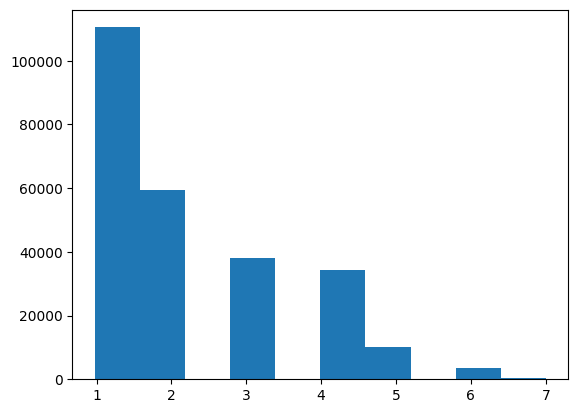

In [ ]:
import matplotlib.pyplot as plt
plt.hist(train['보정된 나이'])

(array([38969., 20822.,     0., 13141.,     0., 12330.,  3458.,     0.,
         1231.,   116.]),
 array([0.97853324, 1.58067991, 2.18282659, 2.78497327, 3.38711994,
        3.98926662, 4.5914133 , 5.19355997, 5.79570665, 6.39785332,
        7.        ]),
 <BarContainer object of 10 artists>)

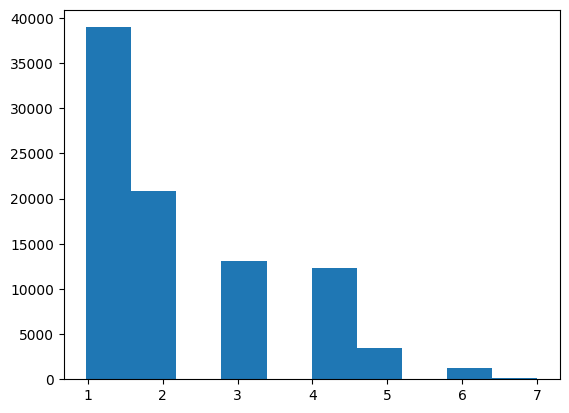

In [ ]:
plt.hist(test['보정된 나이'])

In [ ]:
train[['보정된 나이','임신 성공 여부']].corr()

,보정된 나이,임신 성공 여부
보정된 나이,1.000000,-0.178488
임신 성공 여부,-0.178488,1.000000


### **특정 시술 유형**

In [ ]:
train=train[train['특정 시술 유형']!='GIFT']
train=train[train['특정 시술 유형']!='FER']

In [ ]:
train2=train2[train2['특정 시술 유형']!='GIFT']
train2=train2[train2['특정 시술 유형']!='FER']

In [ ]:
# '특정 시술 유형' 열에 NaN 값이 있는 행을 삭제
train = train.dropna(subset=['특정 시술 유형'])

In [ ]:
train2 = train2.dropna(subset=['특정 시술 유형'])

In [ ]:
# 특정 시술 유형에서 ICSI: BLASTOCYST와 같은 경우에는 두가지 시술을 모두 다 했다는 의미로
# 주요 단어들로 column을 만들어서 해당 시술을 했으면 1, 아니면 0으로
# 특정 시술 유형에 대해 1 또는 0으로 표시할 칼럼 생성
categories = ['ICSI', 'IVF', 'IUI', 'BLASTOCYST', 'AH', 'Generic DI', 'IVI']
for category in categories:
    train[category] = train['특정 시술 유형'].str.contains(category).astype(int)

In [ ]:
for category in categories:
    test[category] = test['특정 시술 유형'].str.contains(category).astype(int)

In [ ]:
train[train['특정 시술 유형']=='Unknown'][['ICSI', 'IVF', 'IUI', 'BLASTOCYST', 'AH', 'Generic DI', 'IVI']].sum()

,0
ICSI,0
IVF,0
IUI,0
BLASTOCYST,0
AH,0
Generic DI,0
IVI,0


In [ ]:
train.drop('특정 시술 유형',axis=1,inplace=True)
test.drop('특정 시술 유형',axis=1,inplace=True)

### **임신 시도 또는 마지막 임신 경과 연수**

In [ ]:
print(train.shape[0],train2.shape[0])

256344 256344


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# NaN 값은 0으로 채우기
train['임신 시도 또는 마지막 임신 경과 연수'].fillna(0,inplace=True)
test['임신 시도 또는 마지막 임신 경과 연수'].fillna(0,inplace=True)

In [ ]:
train2['임신 시도 또는 마지막 임신 경과 연수'].fillna(0,inplace=True)
test2['임신 시도 또는 마지막 임신 경과 연수'].fillna(0,inplace=True)

In [ ]:
train['임신 시도 또는 마지막 임신 경과 연수']=train2['임신 시도 또는 마지막 임신 경과 연수']
test['임신 시도 또는 마지막 임신 경과 연수']=test2['임신 시도 또는 마지막 임신 경과 연수']

In [ ]:
# 1 이상이면 1로 채우기
train.loc[train['임신 시도 또는 마지막 임신 경과 연수']>1,'임신 시도 또는 마지막 임신 경과 연수']=1
test.loc[test['임신 시도 또는 마지막 임신 경과 연수']>1,'임신 시도 또는 마지막 임신 경과 연수']=1

In [ ]:
test['임신 시도 또는 마지막 임신 경과 연수'].isna().sum()

0

In [ ]:
train['임신 시도 또는 마지막 임신 경과 연수'].value_counts()

,count
임신 시도 또는 마지막 임신 경과 연수,
0.0,246986
1.0,9358


In [ ]:
test['임신 시도 또는 마지막 임신 경과 연수'].value_counts()

,count
임신 시도 또는 마지막 임신 경과 연수,
0.0,86774
1.0,3293


In [ ]:
train.groupby('임신 시도 또는 마지막 임신 경과 연수')['임신 성공 여부'].mean()

,임신 성공 여부
임신 시도 또는 마지막 임신 경과 연수,
0.0,0.259934
1.0,0.216606


### **Column Drop**

In [ ]:
# 컬럼 제외
train.drop(['시술 시기 코드','불임 원인 - 여성 요인','대리모 여부','배란 유도 유형','난자 채취 경과일','난자 해동 경과일'],axis=1,inplace=True)
test.drop(['시술 시기 코드','불임 원인 - 여성 요인','대리모 여부','배란 유도 유형','난자 채취 경과일','난자 해동 경과일'],axis=1,inplace=True)

In [ ]:
test[['착상 전 유전 진단 사용 여부','PGD 시술 여부','착상 전 유전 검사 사용 여부','PGS 시술 여부']]=test[['착상 전 유전 진단 사용 여부','PGD 시술 여부','착상 전 유전 검사 사용 여부','PGS 시술 여부']].fillna(0)

In [ ]:
train[['착상 전 유전 진단 사용 여부','PGD 시술 여부','착상 전 유전 검사 사용 여부','PGS 시술 여부']]=train[['착상 전 유전 진단 사용 여부','PGD 시술 여부','착상 전 유전 검사 사용 여부','PGS 시술 여부']].fillna(0)

In [ ]:
train['PGD']=train['PGD 시술 여부']+train['착상 전 유전 진단 사용 여부']
train['PGS']=train['PGS 시술 여부']+train['착상 전 유전 검사 사용 여부']

In [ ]:
train.loc[train['PGD']>1,'PGD']=1
train.loc[train['PGS']>1,'PGS']=1

In [ ]:
test['PGD']=test['PGD 시술 여부']+test['착상 전 유전 진단 사용 여부']
test['PGS']=test['PGS 시술 여부']+test['착상 전 유전 검사 사용 여부']

In [ ]:
test.loc[test['PGD']>1,'PGD']=1
test.loc[test['PGS']>1,'PGS']=1

In [ ]:
train.drop(['착상 전 유전 진단 사용 여부','PGD 시술 여부','착상 전 유전 검사 사용 여부','PGS 시술 여부'],axis=1,inplace=True)
test.drop(['착상 전 유전 진단 사용 여부','PGD 시술 여부','착상 전 유전 검사 사용 여부','PGS 시술 여부'],axis=1,inplace=True)

In [ ]:
train.shape

(256344, 67)

In [ ]:
test.shape

(90067, 66)

### **시술 횟수**

In [ ]:
# 일단 모두 숫자형으로만 바꾸기
train['총 시술 횟수']=train['총 시술 횟수'].str.extract(r'(\d+)').astype(int)
test['총 시술 횟수']=test['총 시술 횟수'].str.extract(r'(\d+)').astype(int)
train['IVF 시술 횟수']=train['IVF 시술 횟수'].str.extract(r'(\d+)').astype(int)
test['IVF 시술 횟수']=test['IVF 시술 횟수'].str.extract(r'(\d+)').astype(int)
train['DI 시술 횟수']=train['DI 시술 횟수'].str.extract(r'(\d+)').astype(int)
test['DI 시술 횟수']=test['DI 시술 횟수'].str.extract(r'(\d+)').astype(int)

In [ ]:
train['클리닉 내 총 시술 횟수']=train['클리닉 내 총 시술 횟수'].str.extract(r'(\d+)').astype(int)
test['클리닉 내 총 시술 횟수']=test['클리닉 내 총 시술 횟수'].str.extract(r'(\d+)').astype(int)

In [ ]:
train[['총 시술 횟수','클리닉 내 총 시술 횟수','IVF 시술 횟수','DI 시술 횟수']].corr()

,총 시술 횟수,클리닉 내 총 시술 횟수,IVF 시술 횟수,DI 시술 횟수
총 시술 횟수,1.000000,0.798783,0.916167,0.373273
클리닉 내 총 시술 횟수,0.798783,1.000000,0.706474,0.355614
IVF 시술 횟수,0.916167,0.706474,1.000000,-0.007012
DI 시술 횟수,0.373273,0.355614,-0.007012,1.000000


In [ ]:
train['기타 시술 횟수']=train['IVF 시술 횟수']+train['DI 시술 횟수']-train['총 시술 횟수']
test['기타 시술 횟수']=test['IVF 시술 횟수']+test['DI 시술 횟수']-test['총 시술 횟수']

In [ ]:
train.drop(['클리닉 내 총 시술 횟수','총 시술 횟수'],axis=1,inplace=True)
test.drop(['클리닉 내 총 시술 횟수','총 시술 횟수'],axis=1,inplace=True)

In [ ]:
train['IVF 시술 횟수'].value_counts()

,count
IVF 시술 횟수,
0,103933
1,58336
2,39174
3,23280
4,13660
6,10159
5,7802


### **출산 횟수**

In [ ]:
train['IVF 출산 횟수']=train['IVF 출산 횟수'].str.extract(r'(\d+)').astype(int)
test['IVF 출산 횟수']=test['IVF 출산 횟수'].str.extract(r'(\d+)').astype(int)
train['DI 출산 횟수']=train['DI 출산 횟수'].str.extract(r'(\d+)').astype(int)
test['DI 출산 횟수']=test['DI 출산 횟수'].str.extract(r'(\d+)').astype(int)
train['총 출산 횟수']=train['총 출산 횟수'].str.extract(r'(\d+)').astype(int)
test['총 출산 횟수']=test['총 출산 횟수'].str.extract(r'(\d+)').astype(int)

In [ ]:
train[['총 출산 횟수','IVF 출산 횟수','DI 출산 횟수']].corr()

,총 출산 횟수,IVF 출산 횟수,DI 출산 횟수
총 출산 횟수,1.000000,0.960738,0.251058
IVF 출산 횟수,0.960738,1.000000,-0.027371
DI 출산 횟수,0.251058,-0.027371,1.000000


In [ ]:
train.drop('총 출산 횟수',axis=1,inplace=True)
test.drop('총 출산 횟수',axis=1,inplace=True)

## **임신 횟수**

In [ ]:
train['총 임신 횟수']=train['총 임신 횟수'].str.extract(r'(\d+)').astype(int)
test['총 임신 횟수']=test['총 임신 횟수'].str.extract(r'(\d+)').astype(int)
train['IVF 임신 횟수']=train['IVF 임신 횟수'].str.extract(r'(\d+)').astype(int)
test['IVF 임신 횟수']=test['IVF 임신 횟수'].str.extract(r'(\d+)').astype(int)
train['DI 임신 횟수']=train['DI 임신 횟수'].str.extract(r'(\d+)').astype(int)
test['DI 임신 횟수']=test['DI 임신 횟수'].str.extract(r'(\d+)').astype(int)

In [ ]:
train[['총 임신 횟수','IVF 임신 횟수','DI 임신 횟수']].corr()

,총 임신 횟수,IVF 임신 횟수,DI 임신 횟수
총 임신 횟수,1.000000,0.962996,0.239470
IVF 임신 횟수,0.962996,1.000000,-0.031066
DI 임신 횟수,0.239470,-0.031066,1.000000


In [ ]:
train.drop('총 임신 횟수',axis=1,inplace=True)
test.drop('총 임신 횟수',axis=1,inplace=True)

In [ ]:
pd.DataFrame(train.isna().sum()[train.isna().sum() > 0])

,0
단일 배아 이식 여부,6290
배아 생성 주요 이유,6290
총 생성 배아 수,6290
미세주입된 난자 수,6290
미세주입에서 생성된 배아 수,6290
이식된 배아 수,6290
미세주입 배아 이식 수,6290
저장된 배아 수,6290
미세주입 후 저장된 배아 수,6290
해동된 배아 수,6290


## **난자 수**

In [ ]:
train[['수집된 신선 난자 수','미세주입된 난자 수','저장된 신선 난자 수']]

,수집된 신선 난자 수,미세주입된 난자 수,저장된 신선 난자 수
0,7.0,5.0,0.0
1,1.0,1.0,0.0
2,8.0,0.0,0.0
3,5.0,4.0,0.0
4,7.0,6.0,0.0
...,...,...,...
256346,11.0,8.0,0.0
256347,5.0,3.0,0.0
256348,10.0,6.0,0.0
256349,3.0,2.0,0.0


#### **혼합해서 생성된 배아 수 column 생성**

In [ ]:
train['혼합해서 생성된 배아 수']=train['총 생성 배아 수']-train['미세주입에서 생성된 배아 수']

In [ ]:
test['혼합해서 생성된 배아 수']=test['총 생성 배아 수']-test['미세주입에서 생성된 배아 수']

#### **난자/배아 성공률 측정**

In [ ]:
train['난자배아성공률']=0

In [ ]:
test['난자배아성공률']=0

In [ ]:
train['미세주입_난자배아성공률']=0.0
train.loc[train['미세주입된 난자 수']!=0,'미세주입_난자배아성공률']=train['미세주입에서 생성된 배아 수']/train['미세주입된 난자 수']

In [ ]:
test['미세주입_난자배아성공률']=0.0
test.loc[test['미세주입된 난자 수']!=0,'미세주입_난자배아성공률']=test['미세주입에서 생성된 배아 수']/test['미세주입된 난자 수']

In [ ]:
train['혼합_난자배아성공률']=0.0
train.loc[train['혼합된 난자 수']!=0,'혼합_난자배아성공률']=train['혼합해서 생성된 배아 수']/train['혼합된 난자 수']

In [ ]:
test['혼합_난자배아성공률']=0.0
test.loc[test['혼합된 난자 수']!=0,'혼합_난자배아성공률']=test['혼합해서 생성된 배아 수']/test['혼합된 난자 수']

In [ ]:
train['해동_난자배아성공률']=0.0
train.loc[train['해동 난자 수']!=0,'해동_난자배아성공률']=train['해동된 배아 수']/train['해동 난자 수']

In [ ]:
test['해동_난자배아성공률']=0.0
test.loc[test['해동 난자 수']!=0,'해동_난자배아성공률']=test['해동된 배아 수']/test['해동 난자 수']

In [ ]:
train['난자배아성공률']=(train['미세주입_난자배아성공률']+train['혼합_난자배아성공률']+train['해동_난자배아성공률'])/3

In [ ]:
test['난자배아성공률']=(test['미세주입_난자배아성공률']+test['혼합_난자배아성공률']+test['해동_난자배아성공률'])/3

In [ ]:
train['난자배아성공률'].isna().sum()

6290

In [ ]:
test['난자배아성공률'].isna().sum()

2176

In [ ]:
train[train['시술 유형']=='IVF'][['난자배아성공률','임신 성공 여부']].corr()

,난자배아성공률,임신 성공 여부
난자배아성공률,1.000000,0.124256
임신 성공 여부,0.124256,1.000000


In [ ]:
train.drop(['미세주입_난자배아성공률','혼합_난자배아성공률','해동_난자배아성공률'],axis=1,inplace=True)
test.drop(['미세주입_난자배아성공률','혼합_난자배아성공률','해동_난자배아성공률'],axis=1,inplace=True)

#### **총 배아 수 from 총 생성 배아 수에서 다시 만들기**

In [ ]:
train[train['시술 유형']=='IVF'][['총 생성 배아 수','임신 성공 여부']].corr()

,총 생성 배아 수,임신 성공 여부
총 생성 배아 수,1.000000,0.146122
임신 성공 여부,0.146122,1.000000


In [ ]:
train['총 배아 수']=train['총 생성 배아 수']+train['해동된 배아 수']

In [ ]:
test['총 배아 수']=test['총 생성 배아 수']+test['해동된 배아 수']

In [ ]:
train[train['시술 유형']=='IVF'][['총 배아 수','임신 성공 여부']].corr()

,총 배아 수,임신 성공 여부
총 배아 수,1.000000,0.150703
임신 성공 여부,0.150703,1.000000


In [ ]:
train.drop('총 생성 배아 수', axis=1,inplace=True)
test.drop('총 생성 배아 수', axis=1,inplace=True)

In [ ]:
print(train.shape[1],test.shape[1])

66 65


#### **혼합 이식 배아수 column  생성**

In [ ]:
train['혼합 이식 배아 수']=train['이식된 배아 수']-train['미세주입 배아 이식 수']

In [ ]:
test['혼합 이식 배아 수']=test['이식된 배아 수']-test['미세주입 배아 이식 수']

In [ ]:
train[train['시술 유형']=='IVF'][['혼합 이식 배아 수','미세주입 배아 이식 수','해동된 배아 수']]

,혼합 이식 배아 수,미세주입 배아 이식 수,해동된 배아 수
0,0.0,2.0,0.0
1,0.0,0.0,0.0
2,2.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,2.0,0.0
...,...,...,...
256346,0.0,2.0,0.0
256347,0.0,2.0,0.0
256348,0.0,2.0,0.0
256349,0.0,2.0,0.0


#### **총 이식된 배아수 from 배아 이식 수 모두 더해서**

In [ ]:
train['총 이식된 배아 수']=train['혼합 이식 배아 수']+train['미세주입 배아 이식 수']+train['해동된 배아 수']

In [ ]:
test['총 이식된 배아 수']=test['혼합 이식 배아 수']+test['미세주입 배아 이식 수']+test['해동된 배아 수']

In [ ]:
train[train['시술 유형']=='IVF'][['총 이식된 배아 수','임신 성공 여부']].corr()

,총 이식된 배아 수,임신 성공 여부
총 이식된 배아 수,1.000000,0.060269
임신 성공 여부,0.060269,1.000000


#### **필요없는 열 drop**

In [ ]:
pd.DataFrame(train.isna().sum()[train.isna().sum()>0])

,0
단일 배아 이식 여부,6290
배아 생성 주요 이유,6290
미세주입된 난자 수,6290
미세주입에서 생성된 배아 수,6290
이식된 배아 수,6290
미세주입 배아 이식 수,6290
저장된 배아 수,6290
미세주입 후 저장된 배아 수,6290
해동된 배아 수,6290
해동 난자 수,6290


In [ ]:
train.drop([ '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '미세주입 후 저장된 배아 수','해동된 배아 수', '해동 난자 수',
            '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수','혼합해서 생성된 배아 수','이식된 배아 수'],axis=1,inplace=True)

In [ ]:
test.drop([ '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '미세주입 후 저장된 배아 수','해동된 배아 수', '해동 난자 수',
            '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수','혼합해서 생성된 배아 수','이식된 배아 수'],axis=1,inplace=True)

In [ ]:
train[[ '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인', '부부 주 불임 원인',
       '부부 부 불임 원인', '불명확 불임 원인']]

,남성 주 불임 원인,남성 부 불임 원인,여성 주 불임 원인,여성 부 불임 원인,부부 주 불임 원인,부부 부 불임 원인,불명확 불임 원인
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
256346,0,0,0,0,0,0,1
256347,0,0,0,0,0,0,0
256348,0,0,0,0,0,0,0
256349,0,0,0,0,0,0,1


## **불임 원인 (남성/여성/부부)**

In [ ]:
print(train['남성 부 불임 원인'].skew())
print(train['남성 주 불임 원인'].skew())
print((train['남성 부 불임 원인']+train['남성 주 불임 원인']).skew())

8.559300123691587
5.665448589129367
4.593946312745646


In [ ]:
(train['남성 부 불임 원인']+train['남성 주 불임 원인']).value_counts()

,count
0,245675
1,10666
2,3


In [ ]:
train['남성 불임 원인']=train['남성 부 불임 원인']+train['남성 주 불임 원인']
train.loc[train['남성 불임 원인']>1,'남성 불임 원인']=1

In [ ]:
test['남성 불임 원인']=test['남성 부 불임 원인']+test['남성 주 불임 원인']
test.loc[test['남성 불임 원인']>1,'남성 불임 원인']=1

In [ ]:
print(train['여성 부 불임 원인'].skew())
print(train['여성 주 불임 원인'].skew())
print((train['여성 부 불임 원인']+train['여성 주 불임 원인']).skew())

8.800440875087082
5.438706689083604
4.506031142003136


In [ ]:
train['여성 불임 원인']=train['여성 부 불임 원인']+train['여성 주 불임 원인']
train.loc[train['여성 불임 원인']>1,'여성 불임 원인']=1

In [ ]:
test['여성 불임 원인']=test['여성 부 불임 원인']+test['여성 주 불임 원인']
test.loc[test['여성 불임 원인']>1,'여성 불임 원인']=1

### **필요없는 열 drop**

In [ ]:
train.drop(['남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인', '부부 주 불임 원인','부부 부 불임 원인'],axis=1,inplace=True)

In [ ]:
test.drop(['남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인', '부부 주 불임 원인','부부 부 불임 원인'],axis=1,inplace=True)

## **불임 원인 - 난관 질환 등**

In [ ]:
print(train[train['시술 유형']=='IVF']['불임 원인 - 난관 질환'].skew())
print(train[train['시술 유형']=='IVF']['불임 원인 - 배란 장애'].skew())
print(train[train['시술 유형']=='IVF']['불임 원인 - 자궁경부 문제'].skew())
print(train[train['시술 유형']=='IVF']['불임 원인 - 자궁내막증'].skew())

2.0525950980705856
2.172471013474431
158.12242095035162
3.2960247323945544


In [ ]:
train['불임 원인 - 자궁경부 문제'].value_counts()

,count
불임 원인 - 자궁경부 문제,
0,256334
1,10


In [ ]:
train.groupby('불임 원인 - 자궁경부 문제')['임신 성공 여부'].mean()

,임신 성공 여부
불임 원인 - 자궁경부 문제,
0,0.258362
1,0.000000


In [ ]:
test['불임 원인 - 자궁경부 문제'].value_counts()

,count
불임 원인 - 자궁경부 문제,
0,90063
1,4


불임 원인 - 자궁경부 문제일 경우 임신 성공 여부 확률을 굉장히 낮게 주기

In [ ]:
print(train[train['시술 유형']=='DI']['불임 원인 - 남성 요인'].skew())
print(train[train['시술 유형']=='DI']['불임 원인 - 정자 농도'].skew())
print(train[train['시술 유형']=='DI']['불임 원인 - 정자 면역학적 요인'].skew())
print(train[train['시술 유형']=='DI']['불임 원인 - 정자 운동성'].skew())
print(train[train['시술 유형']=='DI']['불임 원인 - 정자 형태'].skew())

0.16980619372775477
12.584268652288761
0.0
0.0
56.06692004160174


In [ ]:
train['불임 원인 - 정자 형태'].value_counts()

,count
불임 원인 - 정자 형태,
0,256201
1,143


In [ ]:
train.groupby('불임 원인 - 정자 형태')['임신 성공 여부'].mean()

,임신 성공 여부
불임 원인 - 정자 형태,
0,0.258371
1,0.223776


## **정자 출처**

In [ ]:
train['정자 출처'].isna().sum()

0

In [ ]:
train['정자 출처'].value_counts()

,count
정자 출처,
배우자 제공,229193
기증 제공,27015
미할당,122
배우자 및 기증 제공,14


In [ ]:
# 배우자 제공 및 기증 제공 여부를 나타내는 이진 변수 생성
# 배우자 및 기증 제공이면 둘다 1, 미할당이면 둘다 0
train['정자 출처_배우자제공'] = train['정자 출처'].apply(lambda x: 1 if x in ['배우자 제공', '배우자 및 기증 제공'] else 0)
train['정자 출처_기증제공'] = train['정자 출처'].apply(lambda x: 1 if x in ['기증 제공', '배우자 및 기증 제공'] else 0)

In [ ]:
test['정자 출처_배우자제공'] = test['정자 출처'].apply(lambda x: 1 if x in ['배우자 제공', '배우자 및 기증 제공'] else 0)
test['정자 출처_기증제공'] = test['정자 출처'].apply(lambda x: 1 if x in ['기증 제공', '배우자 및 기증 제공'] else 0)

In [ ]:
train.drop('정자 출처',axis=1,inplace=True)
test.drop('정자 출처',axis=1,inplace=True)

## **정자 보정된 나이 from 정자 기증자 나이**

In [ ]:
train['정자 기증자 나이'].isna().sum()

0

In [ ]:
train['정자 기증자 나이'].value_counts()

,count
정자 기증자 나이,
알 수 없음,230512
만21-25세,5667
만36-40세,5282
만26-30세,5058
만31-35세,4911
만41-45세,3847
만20세 이하,1067


In [ ]:
train['정자 보정된 나이']=train['보정된 나이']
train.loc[train['정자 기증자 나이']=='만20세 이하','정자 보정된 나이']=1
train.loc[train['정자 기증자 나이']=='만21-25세','정자 보정된 나이']=2
train.loc[train['정자 기증자 나이']=='만26-30세','정자 보정된 나이']=3
train.loc[train['정자 기증자 나이']=='만31-35세','정자 보정된 나이']=4
train.loc[train['정자 기증자 나이']=='만36-40세','정자 보정된 나이']=5
train.loc[train['정자 기증자 나이']=='만41-45세','정자 보정된 나이']=6

In [ ]:
train[['정자 보정된 나이','임신 성공 여부']].corr()

,정자 보정된 나이,임신 성공 여부
정자 보정된 나이,1.000000,-0.148461
임신 성공 여부,-0.148461,1.000000


In [ ]:
test['정자 보정된 나이']=test['보정된 나이']
test.loc[test['정자 기증자 나이']=='만20세 이하','정자 보정된 나이']=1
test.loc[test['정자 기증자 나이']=='만21-25세','정자 보정된 나이']=2
test.loc[test['정자 기증자 나이']=='만26-30세','정자 보정된 나이']=3
test.loc[test['정자 기증자 나이']=='만31-35세','정자 보정된 나이']=4
test.loc[test['정자 기증자 나이']=='만36-40세','정자 보정된 나이']=5
test.loc[test['정자 기증자 나이']=='만41-45세','정자 보정된 나이']=6

In [ ]:
train.drop('정자 기증자 나이',axis=1,inplace=True)
test.drop('정자 기증자 나이',axis=1,inplace=True)

## **난자 출처, 기증자 나이**

In [ ]:
train['난자 출처'].value_counts()

,count
난자 출처,
본인 제공,234285
기증 제공,15769
출처 모름,6290


In [ ]:
train['난자 기증 여부']=0.0
train.loc[train['난자 출처']=='기증 제공','난자 기증 여부']=1.0
train.loc[train['난자 출처']=='출처 모름','난자 기증 여부']=0.5

In [ ]:
test['난자 기증 여부']=0.0
test.loc[test['난자 출처']=='기증 제공','난자 기증 여부']=1.0
test.loc[test['난자 출처']=='출처 모름','난자 기증 여부']=0.5

In [ ]:
train['난자 기증 여부'].value_counts()

,count
난자 기증 여부,
0.0,234285
1.0,15769
0.5,6290


In [ ]:
train.drop(['난자 출처','난자 기증자 나이'],axis=1,inplace=True)
test.drop(['난자 출처','난자 기증자 나이'],axis=1,inplace=True)

## **현재 시술용 여부**

In [ ]:
train.select_dtypes(include=['object']).columns

Index(['시술 당시 나이', '시술 유형', '배아 생성 주요 이유'], dtype='object')

In [ ]:
train[train['배아 생성 주요 이유'].isna()]['임신 성공 여부'].mean()

0.1289348171701113

In [ ]:
train.groupby('배아 생성 주요 이유')['임신 성공 여부'].mean()

,임신 성공 여부
배아 생성 주요 이유,
기증용,0.000000
"기증용, 난자 저장용",0.000000
"기증용, 배아 저장용",0.000000
"기증용, 배아 저장용, 현재 시술용",0.350000
"기증용, 현재 시술용",0.379757
난자 저장용,0.000000
"난자 저장용, 배아 저장용",0.000000
"난자 저장용, 배아 저장용, 연구용",0.000000
"난자 저장용, 현재 시술용",0.200000


In [ ]:
train['현재 시술용 여부']=0.0
train.loc[train['배아 생성 주요 이유']=='배아 저장용','현재 시술용 여부']=0.2
train.loc[train['배아 생성 주요 이유'].isna(),'현재 시술용 여부']=0.5
train.loc[train['배아 생성 주요 이유'].str.contains('현재 시술용',na=False),'현재 시술용 여부']=1

In [ ]:
test['현재 시술용 여부']=0.0
test.loc[test['배아 생성 주요 이유']=='배아 저장용','현재 시술용 여부']=0.2
test.loc[test['배아 생성 주요 이유'].isna(),'현재 시술용 여부']=0.5
test.loc[test['배아 생성 주요 이유'].str.contains('현재 시술용',na=False),'현재 시술용 여부']=1

In [ ]:
train.groupby('현재 시술용 여부')['임신 성공 여부'].mean()

,임신 성공 여부
현재 시술용 여부,
0.0,0.000000
0.2,0.000870
0.5,0.128935
1.0,0.275263


나중에 현재 시술용 여부가 0이면 빼고 train -> 현재 시술용 여부가 0인 데이터는 굉장히 작은 값 주기

In [ ]:
train.drop('배아 생성 주요 이유',axis=1,inplace=True)
test.drop('배아 생성 주요 이유',axis=1,inplace=True)

## **난자 혼합 경과일**

In [ ]:
train.columns

Index(['시술 당시 나이', '임신 시도 또는 마지막 임신 경과 연수', '시술 유형', '배란 자극 여부', '단일 배아 이식 여부',
       '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애',
       '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도',
       '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', 'IVF 시술 횟수',
       'DI 시술 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', 'IVF 출산 횟수', 'DI 출산 횟수',
       '미세주입 배아 이식 수', '저장된 배아 수', '수집된 신선 난자 수', '저장된 신선 난자 수', '동결 배아 사용 여부',
       '신선 배아 사용 여부', '기증 배아 사용 여부', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일',
       '임신 성공 여부', '보정된 나이', 'ICSI', 'IVF', 'IUI', 'BLASTOCYST', 'AH',
       'Generic DI', 'IVI', 'PGD', 'PGS', '기타 시술 횟수', '난자배아성공률', '총 배아 수',
       '혼합 이식 배아 수', '총 이식된 배아 수', '남성 불임 원인', '여성 불임 원인', '정자 출처_배우자제공',
       '정자 출처_기증제공', '정자 보정된 나이', '난자 기증 여부', '현재 시술용 여부'],
      dtype='object')

In [ ]:
train[train['난자 혼합 경과일'].isna()]['임신 성공 여부'].mean()

0.1889713956041911

In [ ]:
train[train['난자 혼합 경과일']>0]['임신 성공 여부'].mean()

0.1810344827586207

In [ ]:
train[train['난자 혼합 경과일']==0]['임신 성공 여부'].mean()

0.27708194042047396

In [ ]:
train.loc[train['난자 혼합 경과일']!=0,'난자 혼합 경과일']=1

In [ ]:
test.loc[test['난자 혼합 경과일']!=0,'난자 혼합 경과일']=1

In [ ]:
train.drop('배아 해동 경과일',axis=1,inplace=True)
test.drop('배아 해동 경과일',axis=1,inplace=True)

## **IVF/DI Split**

In [ ]:
train.select_dtypes(include=['object','bool']).columns

Index(['시술 당시 나이', '시술 유형'], dtype='object')

In [ ]:
test.select_dtypes(include=['object','bool']).columns

Index(['시술 당시 나이', '시술 유형'], dtype='object')

In [ ]:
train.drop('시술 당시 나이',axis=1,inplace=True)
test.drop('시술 당시 나이',axis=1,inplace=True)

#### **사용된 신선 난자 수 column 생성**

In [ ]:
train['사용된 신선 난자 수']=train['수집된 신선 난자 수']-train['저장된 신선 난자 수']
train.loc[train['사용된 신선 난자 수']<0,'사용된 신선 난자 수']=0.0

In [ ]:
test['사용된 신선 난자 수']=test['수집된 신선 난자 수']-test['저장된 신선 난자 수']
test.loc[test['사용된 신선 난자 수']<0,'사용된 신선 난자 수']=0.0

#### **총 이식된 배아 수가 아닌 동결, 혼합, 미세주입 배아 이식 수로**

In [ ]:
train['동결 배아 이식 수']=train['총 이식된 배아 수']-train['혼합 이식 배아 수']-train['미세주입 배아 이식 수']

In [ ]:
test['동결 배아 이식 수']=test['총 이식된 배아 수']-test['혼합 이식 배아 수']-test['미세주입 배아 이식 수']

In [ ]:
train.columns

Index(['임신 시도 또는 마지막 임신 경과 연수', '시술 유형', '배란 자극 여부', '단일 배아 이식 여부',
       '불명확 불임 원인', '불임 원인 - 난관 질환', '불임 원인 - 남성 요인', '불임 원인 - 배란 장애',
       '불임 원인 - 자궁경부 문제', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도',
       '불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', 'IVF 시술 횟수',
       'DI 시술 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', 'IVF 출산 횟수', 'DI 출산 횟수',
       '미세주입 배아 이식 수', '저장된 배아 수', '수집된 신선 난자 수', '저장된 신선 난자 수', '동결 배아 사용 여부',
       '신선 배아 사용 여부', '기증 배아 사용 여부', '난자 혼합 경과일', '배아 이식 경과일', '임신 성공 여부',
       '보정된 나이', 'ICSI', 'IVF', 'IUI', 'BLASTOCYST', 'AH', 'Generic DI', 'IVI',
       'PGD', 'PGS', '기타 시술 횟수', '난자배아성공률', '총 배아 수', '혼합 이식 배아 수',
       '총 이식된 배아 수', '남성 불임 원인', '여성 불임 원인', '정자 출처_배우자제공', '정자 출처_기증제공',
       '정자 보정된 나이', '난자 기증 여부', '현재 시술용 여부', '사용된 신선 난자 수', '동결 배아 이식 수'],
      dtype='object')

In [ ]:
train.drop(['수집된 신선 난자 수','저장된 신선 난자 수','저장된 배아 수','총 이식된 배아 수'],axis=1,inplace=True)
test.drop(['수집된 신선 난자 수','저장된 신선 난자 수','저장된 배아 수','총 이식된 배아 수'],axis=1,inplace=True)

In [ ]:
train.shape

(256344, 50)

In [ ]:
test.shape

(90067, 49)

In [ ]:
train_IVF=train[train['시술 유형']=='IVF']
train_DI=train[train['시술 유형']=='DI']
test_IVF=test[test['시술 유형']=='IVF']
test_DI=test[test['시술 유형']=='DI']

In [ ]:
train_IVF=train_IVF.drop('시술 유형',axis=1)
train_DI=train_DI.drop('시술 유형',axis=1)
test_IVF=test_IVF.drop('시술 유형',axis=1)
test_DI=test_DI.drop('시술 유형',axis=1)

In [ ]:
train_DI.isna().sum()[train_DI.isna().sum() > 0]

,0
단일 배아 이식 여부,6290
미세주입 배아 이식 수,6290
동결 배아 사용 여부,6290
신선 배아 사용 여부,6290
기증 배아 사용 여부,6290
배아 이식 경과일,6290
난자배아성공률,6290
총 배아 수,6290
혼합 이식 배아 수,6290
사용된 신선 난자 수,6290


In [ ]:
test_DI.isna().sum()[test_DI.isna().sum() > 0]

,0
단일 배아 이식 여부,2176
미세주입 배아 이식 수,2176
동결 배아 사용 여부,2176
신선 배아 사용 여부,2176
기증 배아 사용 여부,2176
배아 이식 경과일,2176
난자배아성공률,2176
총 배아 수,2176
혼합 이식 배아 수,2176
사용된 신선 난자 수,2176


In [ ]:
# train 데이터에서 NaN 값을 포함하는 컬럼 모두 삭제
train_DI=train_DI.dropna(axis=1, how='all')
test_DI=test_DI.dropna(axis=1, how='all')

In [ ]:
print(train_IVF.shape)
print(test_IVF.shape)
print(train_DI.shape)
print(test_DI.shape)

(250054, 49)
(87891, 48)
(6290, 38)
(2176, 37)


In [ ]:
train_IVF.isna().sum()[train_IVF.isna().sum() > 0]

,0
배아 이식 경과일,37271


In [ ]:
test_IVF.isna().sum()[test_IVF.isna().sum() > 0]

,0
배아 이식 경과일,13070


In [ ]:
train_IVF.to_csv('/content/drive/MyDrive/Aimers_data/train_IVF2.csv',index=False)
train_DI.to_csv('/content/drive/MyDrive/Aimers_data/train_DI2.csv',index=False)
test_IVF.to_csv('/content/drive/MyDrive/Aimers_data/test_IVF2.csv',index=False)
test_DI.to_csv('/content/drive/MyDrive/Aimers_data/test_DI2.csv',index=False)